In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

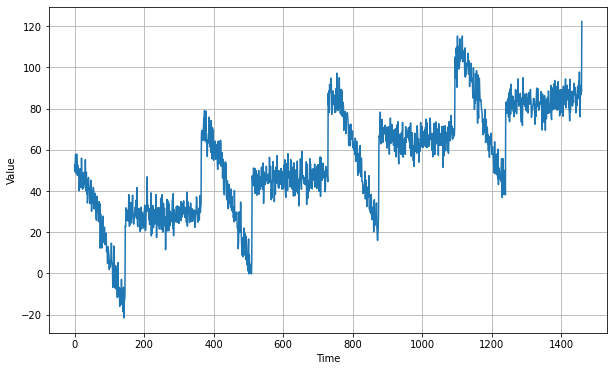

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# simple RNN forecasting

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/home/nikhil/anaconda3/envs/deepl/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
8/8 [==============================] - 2s 21ms/step - loss: 50.2173 - mae: 50.7170
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 23.0009 - mae: 23.4933
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 19.2075 - mae: 19.7004
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 16.9702 - mae: 17.4606
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 15.4094 - mae: 15.8988
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 14.7507 - mae: 15.2367
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 14.3058 - mae: 14.7931
Epoch 8/100
8/8 [==============================] - 0s 19ms/step - loss: 14.0615 - mae: 14.5512
Epoch 9/100
8/8 [==============================] - 0s 19ms/step - loss: 13.7812 - mae: 14.2687
Epoch 10/100
8/8 [==============================] - 0s 19ms/step - loss: 13.5641 - mae: 14.0522
Epoch 11/100
8/8 [==============================]

8/8 [==============================] - 0s 21ms/step - loss: 1732.8389 - mae: 1733.3389
Epoch 86/100
8/8 [==============================] - 0s 19ms/step - loss: 1777.5637 - mae: 1778.0637
Epoch 87/100
8/8 [==============================] - 0s 19ms/step - loss: 2103.5710 - mae: 2104.0710
Epoch 88/100
8/8 [==============================] - 0s 19ms/step - loss: 7140.4414 - mae: 7140.9414
Epoch 89/100
8/8 [==============================] - 0s 19ms/step - loss: 9922.1768 - mae: 9922.6768
Epoch 90/100
8/8 [==============================] - 0s 19ms/step - loss: 18633.7090 - mae: 18634.2109
Epoch 91/100
8/8 [==============================] - 0s 19ms/step - loss: 14234.3506 - mae: 14234.8506
Epoch 92/100
8/8 [==============================] - 0s 19ms/step - loss: 13602.3779 - mae: 13602.8779
Epoch 93/100
8/8 [==============================] - 0s 19ms/step - loss: 13449.9004 - mae: 13450.4004
Epoch 94/100
8/8 [==============================] - 0s 19ms/step - loss: 10438.3066 - mae: 10438.8066
Epo

(1e-07, 0.0001, 0.0, 30.0)

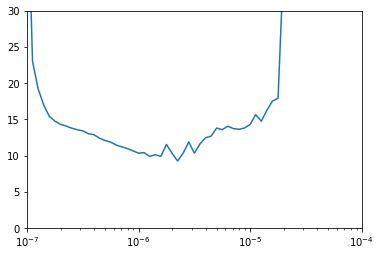

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

/home/nikhil/anaconda3/envs/deepl/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
8/8 [==============================] - 2s 66ms/step - loss: 54.8860 - mae: 55.3846 - val_loss: 53.7725 - val_mae: 54.2725
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 2/500
8/8 [==============================] - 0s 32ms/step - loss: 35.4595 - mae: 35.9564 - val_loss: 17.5199 - val_mae: 18.0161
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 3/500
8/8 [==============================] - 0s 30ms/step - loss: 22.5446 - mae: 23.0386 - val_loss: 18.8168 - val_mae: 19.3137
Epoch 4/500
8/8 [==============================] - 0s 31ms/step - loss: 16.2156 - mae: 16.7054 - val_loss: 20.0783 - val_mae: 20.5770
Epoch 5/500
8/8 [==============================] - 0s 30ms/step - loss: 13.7456 - mae: 14.2346 - val_loss: 6.8457 - val_mae: 7.3288
INFO:tensorflow:Assets written to: my_checkpoint/assets
Epoch 6/500
8/8 [==============================] - 0s 31ms/step - loss: 11.3547 - mae: 11.8351 - val_loss: 7.2706 - val_mae: 7.7554
Epoch 7/500
8/8 [===============

8/8 [==============================] - 0s 30ms/step - loss: 5.7947 - mae: 6.2725 - val_loss: 6.6451 - val_mae: 7.1294
Epoch 60/500
8/8 [==============================] - 0s 30ms/step - loss: 5.6307 - mae: 6.1075 - val_loss: 5.5807 - val_mae: 6.0649
Epoch 61/500
8/8 [==============================] - 0s 30ms/step - loss: 5.4900 - mae: 5.9733 - val_loss: 5.1648 - val_mae: 5.6429
Epoch 62/500
8/8 [==============================] - 0s 30ms/step - loss: 5.7959 - mae: 6.2788 - val_loss: 6.7675 - val_mae: 7.2550
Epoch 63/500
8/8 [==============================] - 0s 31ms/step - loss: 5.8492 - mae: 6.3293 - val_loss: 5.5543 - val_mae: 6.0376
Epoch 64/500
8/8 [==============================] - 0s 30ms/step - loss: 6.0058 - mae: 6.4879 - val_loss: 5.3563 - val_mae: 5.8395
Epoch 65/500
8/8 [==============================] - 0s 30ms/step - loss: 6.2938 - mae: 6.7772 - val_loss: 5.0566 - val_mae: 5.5311
Epoch 66/500
8/8 [==============================] - 0s 30ms/step - loss: 5.7496 - mae: 6.2315 - 

8/8 [==============================] - 0s 31ms/step - loss: 5.3134 - mae: 5.7963 - val_loss: 6.3334 - val_mae: 6.8156
Epoch 120/500
8/8 [==============================] - 0s 37ms/step - loss: 5.1218 - mae: 5.6007 - val_loss: 4.9825 - val_mae: 5.4659
Epoch 121/500
8/8 [==============================] - 0s 31ms/step - loss: 4.9230 - mae: 5.4008 - val_loss: 5.5421 - val_mae: 6.0270
Epoch 122/500
8/8 [==============================] - 0s 35ms/step - loss: 5.5261 - mae: 6.0098 - val_loss: 5.3486 - val_mae: 5.8317
Epoch 123/500
8/8 [==============================] - 0s 39ms/step - loss: 5.0603 - mae: 5.5404 - val_loss: 5.4108 - val_mae: 5.8932
Epoch 124/500
8/8 [==============================] - 0s 31ms/step - loss: 4.8919 - mae: 5.3721 - val_loss: 4.9513 - val_mae: 5.4383
Epoch 125/500
8/8 [==============================] - 0s 31ms/step - loss: 4.8796 - mae: 5.3609 - val_loss: 5.1420 - val_mae: 5.6219
Epoch 126/500
8/8 [==============================] - 0s 32ms/step - loss: 4.6771 - mae: 5.

In [8]:
model = keras.models.load_model("my_checkpoint")

In [9]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

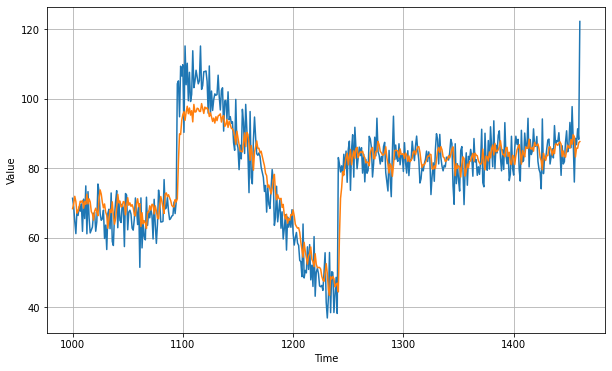

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.3282213

# Sequence to Sequence forecasting

In [12]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]


In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/home/nikhil/anaconda3/envs/deepl/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
8/8 [==============================] - 2s 22ms/step - loss: 52.3618 - mae: 52.8614
Epoch 2/100
8/8 [==============================] - 0s 29ms/step - loss: 25.4714 - mae: 25.9671
Epoch 3/100
8/8 [==============================] - 0s 29ms/step - loss: 23.5029 - mae: 23.9972
Epoch 4/100
8/8 [==============================] - 0s 26ms/step - loss: 21.1367 - mae: 21.6294
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 19.4762 - mae: 19.9674
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 18.6742 - mae: 19.1647
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 18.1698 - mae: 18.6587
Epoch 8/100
8/8 [==============================] - 0s 20ms/step - loss: 17.7679 - mae: 18.2568
Epoch 9/100
8/8 [==============================] - 0s 21ms/step - loss: 17.4389 - mae: 17.9280
Epoch 10/100
8/8 [==============================] - 0s 26ms/step - loss: 17.0989 - mae: 17.5875
Epoch 11/100
8/8 [==============================]

8/8 [==============================] - 0s 21ms/step - loss: 49.4669 - mae: 49.9662
Epoch 87/100
8/8 [==============================] - 0s 19ms/step - loss: 50.0162 - mae: 50.5158
Epoch 88/100
8/8 [==============================] - 0s 20ms/step - loss: 50.7769 - mae: 51.2765
Epoch 89/100
8/8 [==============================] - 0s 20ms/step - loss: 58.3083 - mae: 58.8083
Epoch 90/100
8/8 [==============================] - 0s 20ms/step - loss: 62.8067 - mae: 63.3065
Epoch 91/100
8/8 [==============================] - 0s 19ms/step - loss: 65.4932 - mae: 65.9930
Epoch 92/100
8/8 [==============================] - 0s 20ms/step - loss: 62.8643 - mae: 63.3642
Epoch 93/100
8/8 [==============================] - 0s 20ms/step - loss: 81.3788 - mae: 81.8786
Epoch 94/100
8/8 [==============================] - 0s 20ms/step - loss: 79.6877 - mae: 80.1875
Epoch 95/100
8/8 [==============================] - 0s 20ms/step - loss: 92.4389 - mae: 92.9387
Epoch 96/100
8/8 [==============================] - 0

(1e-07, 0.0001, 0.0, 30.0)

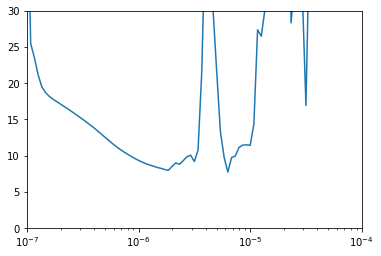

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 2s 67ms/step - loss: 54.1429 - mae: 54.6414 - val_loss: 17.9208 - val_mae: 18.4157
Epoch 2/500
8/8 [==============================] - 0s 33ms/step - loss: 34.1722 - mae: 34.6694 - val_loss: 20.5482 - val_mae: 21.0441
Epoch 3/500
8/8 [==============================] - 0s 33ms/step - loss: 27.5075 - mae: 28.0027 - val_loss: 37.8713 - val_mae: 38.3707
Epoch 4/500
8/8 [==============================] - 0s 32ms/step - loss: 21.0646 - mae: 21.5578 - val_loss: 25.2685 - val_mae: 25.7675
Epoch 5/500
8/8 [==============================] - 0s 32ms/step - loss: 17.1768 - mae: 17.6667 - val_loss: 15.3556 - val_mae: 15.8505
Epoch 6/500
8/8 [==============================] - 0s 33ms/step - loss: 15.0383 - mae: 15.5247 - val_loss: 9.4217 - val_mae: 9.9070
Epoch 7/500
8/8 [==============================] - 0s 34ms/step - loss: 13.9508 - mae: 14.4372 - val_loss: 9.1617 - val_mae: 9.6475
Epoch 8/500
8/8 [==============================] - 0s 32ms/step - 

8/8 [==============================] - 0s 31ms/step - loss: 6.3027 - mae: 6.7813 - val_loss: 5.4634 - val_mae: 5.9396
Epoch 64/500
8/8 [==============================] - 0s 30ms/step - loss: 6.2800 - mae: 6.7595 - val_loss: 5.6596 - val_mae: 6.1384
Epoch 65/500
8/8 [==============================] - 0s 30ms/step - loss: 6.2597 - mae: 6.7382 - val_loss: 5.4920 - val_mae: 5.9685
Epoch 66/500
8/8 [==============================] - 1s 64ms/step - loss: 6.2370 - mae: 6.7161 - val_loss: 5.5227 - val_mae: 5.9986
Epoch 67/500
8/8 [==============================] - 0s 31ms/step - loss: 6.2181 - mae: 6.6968 - val_loss: 5.5079 - val_mae: 5.9838
Epoch 68/500
8/8 [==============================] - 0s 29ms/step - loss: 6.1976 - mae: 6.6767 - val_loss: 5.5154 - val_mae: 5.9910
Epoch 69/500
8/8 [==============================] - 0s 29ms/step - loss: 6.1796 - mae: 6.6588 - val_loss: 5.5412 - val_mae: 6.0176
Epoch 70/500
8/8 [==============================] - 0s 29ms/step - loss: 6.1641 - mae: 6.6427 - 

In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

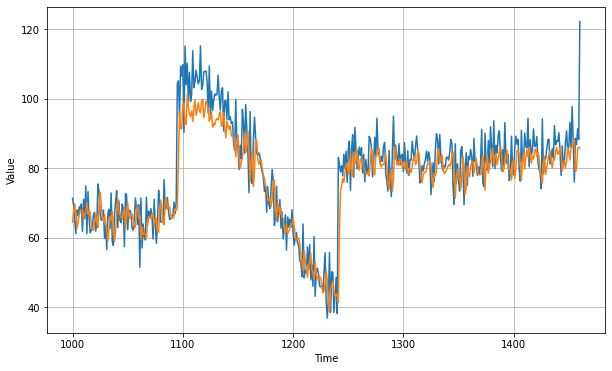

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.458883